## Building a deep learning calculator

In this HW we will use seq2seq for building a calculator. The input will be an equation and the solution will be generated by the network.

### Data Generation

In this task we will generate our own data! We will use three operators (addition, multiplication and subtraction) and work with positive integer numbers in some range. Here are examples of correct inputs and outputs:

    Input: '1+2'
    Output: '3'
    
    Input: '0-99'
    Output: '-99'

*Note, that there are no spaces between operators and operands.*




In [ ]:
import random

In [ ]:
def generate_equations(allowed_operators, dataset_size, min_value, max_value):
    """Generates pairs of equations and solutions to them.
    
       Each equation has a form of two integers with an operator in between.
       Each solution is an integer with the result of the operaion.
    
        allowed_operators: list of strings, allowed operators.
        dataset_size: an integer, number of equations to be generated.
        min_value: an integer, min value of each operand.
        max_value: an integer, max value of each operand.

        result: a list of tuples of strings (equation, solution).
    """
    sample = []
    for _ in range(dataset_size):
        left_operand = str(random.randint(min_value, max_value))
        right_operand = str(random.randint(min_value, max_value))
        operator = random.choice(allowed_operators)
        operation = left_operand+operator+right_operand
        sample.append((operation, str(eval(operation))))
    return sample

In [ ]:
from sklearn.model_selection import train_test_split
allowed_operators = ['+', '-','*']
dataset_size = 100000
data = generate_equations(allowed_operators, dataset_size, min_value=0, max_value=10000)

train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)

In [ ]:
train_set[0:10]

[('4894-7610', '-2716'),
 ('3375+9812', '13187'),
 ('2738+2939', '5677'),
 ('8011+7670', '15681'),
 ('7504*7056', '52948224'),
 ('8310-2349', '5961'),
 ('8266+7159', '15425'),
 ('8675*2463', '21366525'),
 ('9189*4778', '43905042'),
 ('5925-2407', '3518')]

### Building vocabularies and tokenization function

We now need to build vocabularies that map strings to token ids and vice versa. We're gonna need these  when we feed training data into  the model or convert output matrices into words. 

Pay a close attention to the special characters you need to add for the vocabulary:


*    End of equation / solution token
*    Begining of equation / solution token
*    Padding token

Please note that in the exercise we do not need the <UNK> token



In [ ]:
#build a vocabulary  string --> tokenId
#build a reverse vocabulary  tokenId --> string
#build a tokenizer (i.e. a function which takes a string and returns tokenids)

In [ ]:
import sys
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
from copy import deepcopy

class Vocab:
    def __init__(self, tokens, bos="_BOS_", eos="_EOS_", unk='_UNK_'):
        """
        A special class that converts lines of tokens into matrices and backwards
        """
        assert all(tok in tokens for tok in (bos, eos, unk))
        self.tokens = tokens
        self.token_to_ix = {t: i for i, t in enumerate(tokens)}
        self.bos, self.eos, self.unk = bos, eos, unk
        self.bos_ix = self.token_to_ix[bos]
        self.eos_ix = self.token_to_ix[eos]
        self.unk_ix = self.token_to_ix[unk]
        self.max_len=20

    def __len__(self):
        return len(self.tokens)

    @staticmethod
    def from_lines(lines, bos="_BOS_", eos="_EOS_", unk='_UNK_'):
        flat_lines = '\n'.join(list(lines)).split()
        tokens = sorted(set(c for t in flat_lines for c in t))
        tokens = [t for t in tokens if t not in (bos, eos, unk) and len(t)]
        tokens = [bos, eos, unk] + tokens
        return Vocab(tokens, bos, eos, unk)

    def tokenize(self, string):
        """converts string to a list of tokens"""
        tokens = [tok if tok in self.token_to_ix else self.unk
                  for tok in list(string)]
        return [self.bos] + tokens + [self.eos]

    def to_matrix(self, lines, dtype=torch.int64):
        """
        convert variable length token sequences into  fixed size matrix
        example usage:
        # >>>print(to_matrix(words[:3],source_to_ix))
        [[15 22 21 28 27 13 -1 -1 -1 -1 -1]
         [30 21 15 15 21 14 28 27 13 -1 -1]
         [25 37 31 34 21 20 37 21 28 19 13]]
        """
        lines = list(map(self.tokenize, lines))
        max_len = self.max_len

        matrix = torch.full((len(lines), max_len), self.eos_ix, dtype=dtype)
        for i, seq in enumerate(lines):
            row_ix = list(map(self.token_to_ix.get, seq))[:max_len]
            matrix[i, :len(row_ix)] = torch.as_tensor(row_ix)

        return matrix

    def to_lines(self, matrix, crop=True):
        """
        Convert matrix of token ids into strings
        :param matrix: matrix of tokens of int32, shape=[batch,time]
        :param crop: if True, crops BOS and EOS from line
        :return:
        """
        lines = []
        for line_ix in map(list, matrix):
            if crop:
                if line_ix[0] == self.bos_ix:
                    line_ix = line_ix[1:]
                if self.eos_ix in line_ix:
                    line_ix = line_ix[:line_ix.index(self.eos_ix)]
            line = ' '.join(self.tokens[i] for i in line_ix)
            lines.append(line)
        return lines

    def compute_mask(self, input_ix):
        """ compute a boolean mask that equals "1" until first EOS (including that EOS) """
        return F.pad(torch.cumsum(input_ix == self.eos_ix, dim=-1)[..., :-1] < 1, pad=(1, 0, 0, 0), value=True)

### Encoder-decoder model

The code below contains a template for a simple encoder-decoder model: single GRU encoder/decoder.
**Please note that some places require change and your implementation.**

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class BasicModel(nn.Module):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128):
        """
        A simple encoder-decoder seq2seq model
        """

        super().__init__()

        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size

        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)
        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True)

        self.dec_start = nn.Linear(hid_size, hid_size)
        self.dec0 = nn.GRUCell(emb_size, hid_size)
        self.logits = nn.Linear(hid_size, len(out_voc))

    def forward(self, inp, out):
        """ Apply model in training mode """

        initial_state = self.encode(inp)
        return self.decode(initial_state, out)

    def encode(self, inp, **flags):
        """
        Takes symbolic input sequence, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :returns: initial decoder state tensors, one or many
        """

        inp_emb = self.emb_inp(inp)
        batch_size = inp.shape[0]

        enc_seq, last_state_but_not_really = self.enc0(inp_emb)
        # enc_seq: [batch, time, hid_size], last_state: [batch, hid_size]

        # last_state is not actually last because of padding, let's find the real last_state
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]  # shape: [batch_size, hid_size]
        return [self.dec_start(last_state)]

    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits for next tokens
        :param prev_state: a list of previous decoder state tensors, same as returned by encode(...)
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch, len(out_voc)]
        """

        x = self.emb_out(prev_tokens)
        x = self.dec0(x, prev_state[0])
        return [x], self.logits(x)

    def decode(self, initial_state, out_tokens, **flags):
        """ Iterate over reference tokens (out_tokens) with decode_step """

        batch_size = out_tokens.shape[0]
        state = initial_state

        # initial logits: always predict BOS
        onehot_bos = F.one_hot(torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64),
                               num_classes=len(self.out_voc)).to(device=out_tokens.device)
        first_logits = torch.log(onehot_bos.to(torch.float32) + 1e-9)

        logits_sequence = [first_logits]
        for i in range(out_tokens.shape[1] - 1):
            state, logits = self.decode_step(state, out_tokens[:, i])
            logits_sequence.append(logits)
        return torch.stack(logits_sequence, dim=1)

    def decode_inference(self, initial_state, max_len=100, **flags):
        """ Generate translations from model (greedy version) """

        batch_size, device = len(initial_state[0]), initial_state[0].device
        state = initial_state
        outputs = [torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64,
                              device=device)]
        all_states = [initial_state]

        for i in range(max_len):
            state, logits = self.decode_step(state, outputs[-1])
            outputs.append(logits.argmax(dim=-1))
            all_states.append(state)
        return torch.stack(outputs, dim=1), all_states

    def decode_inference_beam_search(self, initial_state, beam_size, max_len=100, **flags):
        batch_size, device = len(initial_state[0]), initial_state[0].device
        state = initial_state

        outputs = [[(self.out_voc.bos_ix,)] * batch_size]
        probs = np.zeros(shape=(beam_size, batch_size))
        states = [deepcopy(initial_state) for _ in range(beam_size)]
        hypos = [[] for _ in range(batch_size)]

        for _ in range(max_len):
            next_beams = [[] for _ in range(batch_size)]
            states_history = []
            for i in range(len(outputs)):
                prev_tokens = torch.tensor([tokens[-1] for tokens in outputs[i]], device=device)

                cur_states, logits = self.decode_step(states[i], prev_tokens)
                logits = torch.log_softmax(logits, dim=-1).detach().cpu().numpy()
                states_history.append(cur_states)

                for b, logit in enumerate(logits):
                    for idx in np.argpartition(logit, -beam_size)[-beam_size:]:
                        if idx == 1 and np.exp(logit[idx]) < 0.6:
                            idx = 228
                        next_beams[b].append([outputs[i][b] + (idx,), logit[idx] + probs[i, b], i])

            outputs = [[None] * batch_size for _ in range(beam_size)]
            for i in range(batch_size):
                next_beams[i].sort(key=lambda x: x[1], reverse=True)
                for j in range(beam_size):
                    outputs[j][i], probs[j, i], beam_idx = next_beams[i][j]
                    if outputs[j][i][-1] == 1:
                        hypos[i].append([probs[j, i] + 0.1 * _, outputs[j][i]])
                    states[j][0][i] = states_history[beam_idx][0][i]

        for i in range(len(hypos)):
            if not hypos[i]:
                hypos[i].append([0, outputs[0][i]])
            hypos[i].sort()
        return [hypo[-1][1] for hypo in hypos]

    def translate_lines(self, inp_lines, device, beam_size=None, **kwargs):
        inp = self.inp_voc.to_matrix(inp_lines).to(device)
        initial_state = self.encode(inp)
        if beam_size is None:
            out_ids, states = self.decode_inference(initial_state, **kwargs)
        else:
            out_ids, states = self.decode_inference_beam_search(initial_state, beam_size, **kwargs), None
        return self.out_voc.to_lines(out_ids), states

### Training loop

Training encoder-decoder models isn't that different from any other models: sample batches, compute loss, backprop and update.

For training loss we will use ***torch.nn.NLLLoss*** please note that the loss should not be calculated with the padding token. (For ignoring specific labels please look at ***torch.nn.NLLLoss*** documentation 


In [ ]:
def compute_loss(model, inp, out, **flags):
    """
    Compute nllloss according to mask
    or we could use NLLLoss(ignore_index=ignore_index)
    """

    # [batch_size, out_len]
    mask = model.out_voc.compute_mask(out)  
    targets_one_hot = F.one_hot(out, len(model.out_voc)).to(torch.float32)

    # outputs of the model, [batch_size, out_len, num_tokens]
    logits_seq = model(inp, out)

    # log-probabilities of all tokens at all steps, [batch_size, out_len, num_tokens]
    logprobs_seq = torch.log_softmax(logits_seq, dim=-1)

    # log-probabilities of correct outputs, [batch_size, out_len]
    logp_out = (logprobs_seq * targets_one_hot).sum(dim=-1)

    # average cross-entropy over tokens where mask == True
    return -logp_out[mask].mean()

In [ ]:
import copy
from IPython.core.display import clear_output
from matplotlib import pyplot as plt
from tqdm import tqdm

train_inp = np.array([t[0] for t in train_set])
train_out = np.array([t[1] for t in train_set])

dev_inp = np.array([t[0] for t in test_set])
dev_out = np.array([t[1] for t in test_set])

inp_voc = Vocab.from_lines(train_inp)
out_voc = Vocab.from_lines(train_out)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model = BasicModel(inp_voc, out_voc).to(device)

In [ ]:
def train_model(model, n_iters=15000, batch_size=32, lr=1e-3, n_iters_break=10_000, clip=2):
    metrics = {'train_loss': [], 'test_loss': []}
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    best_weights = model.state_dict()
    best_loss = np.inf
    best_step = -1
    with tqdm(range(n_iters)) as progress_bar:
        for i in progress_bar:
            step = len(metrics['train_loss']) + 1
            batch_ix = np.random.randint(len(train_inp), size=batch_size)
            batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device)
            batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)

            opt.zero_grad()
            loss_t = compute_loss(model, batch_inp, batch_out)
            loss_t.backward()
            torch.nn.utils.clip_grad_value_(model.parameters(), clip)
            opt.step()

            metrics['train_loss'].append((step, loss_t.item()))
            if step % 100 == 0:
                loss = 0
                for i in range(dev_inp.shape[0] // batch_size):
                    batch_inp = inp_voc.to_matrix([dev_inp[batch_size * i:batch_size * (i + 1)]]).to(device)
                    batch_out = out_voc.to_matrix([dev_out[batch_size * i:batch_size * (i + 1)]]).to(device)
                    loss += compute_loss(model, batch_inp, batch_out).item()
                metrics['test_loss'].append((step, loss/i))

                if loss < best_loss:
                    best_loss = loss
                    best_step = step
                    best_weights = copy.deepcopy(model.state_dict())
                elif step - best_step >= n_iters_break:
                    break

                clear_output(wait=True)
                plt.figure(figsize=(12, 4))
                for i, (name, history) in enumerate(metrics.items()):
                    plt.subplot(1, len(metrics), i + 1)
                    plt.title(name)
                    plt.plot(*zip(*history))
                    plt.grid()
                plt.show()

                print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)

                batch_ix = np.random.randint(len(train_inp), size=1)
                batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device)
                batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)
                mask = model.out_voc.compute_mask(batch_out)  # [batch_size, out_len]
                targets_one_hot = F.one_hot(batch_out, len(model.out_voc)).to(torch.float32)

                logits_seq = model(batch_inp, batch_out)

                logprobs_seq = torch.log_softmax(logits_seq, dim=-1)
                y_hat = int(model.translate_lines(train_inp[batch_ix], device=device)[0][0].replace(" ", ""))
                y = int(train_out[batch_ix][0])
                mape = np.abs(y-y_hat)/np.abs(y)
                print(f"\n{train_inp[batch_ix][0]}={y}, predicted={y_hat}, MAPE={mape}")

    model.load_state_dict(best_weights)
    return best_loss

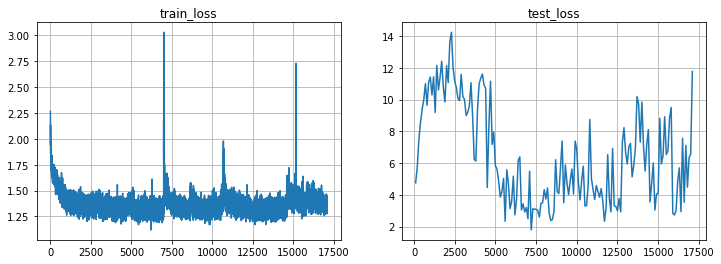

Mean loss=1.375


 34%|███▍      | 17115/50000 [10:51<40:26, 13.55it/s]


4139*5783=23935837, predicted=21111151, MAPE=0.1180107468144941


 34%|███▍      | 17196/50000 [10:55<20:49, 26.25it/s]


1117.2791299819946

In [ ]:
basic_model = BasicModel(inp_voc, out_voc).to(device)
train_model(basic_model, batch_size=32, lr=1e-3*5, n_iters=50000)

let's check model on 10 random samples from test set

In [ ]:
model = basic_model
model.eval()
for _ in range(10):
  batch_ix = np.random.randint(len(dev_inp), size=1)
  batch_inp = inp_voc.to_matrix(dev_inp[batch_ix]).to(device)
  batch_out = out_voc.to_matrix(dev_out[batch_ix]).to(device)
  mask = model.out_voc.compute_mask(batch_out)  # [batch_size, out_len]
  targets_one_hot = F.one_hot(batch_out, len(model.out_voc)).to(torch.float32)
  logits_seq = model(batch_inp, batch_out)
  logprobs_seq = torch.log_softmax(logits_seq, dim=-1)
  y = dev_out[batch_ix][0]
  y_hat = model.translate_lines(dev_inp[batch_ix], device=device)[0][0].replace(" ", "")
  print(f"{dev_inp[batch_ix][0]}={y}, predicted={y_hat}")

5725*5406=30949350, predicted=27777760
6513+7160=13673, predicted=13076
9875-3945=5930, predicted=5906
9565*4938=47231970, predicted=42777760
4496-2392=2104, predicted=2190
5548+2174=7722, predicted=7906
806+1200=2006, predicted=2006
8775*6391=56081025, predicted=59777905
8788-472=8316, predicted=8000
6928*3872=26825216, predicted=2277766


as we model infer order of magnitude correctly, but do calculation a bit inaccurate. suggestion for improvement - 1) tune model hyperparameters (e.g. increase hidden size and change clip value) 2) do early stopping and searching best model on MAPE

## Adding Attention Layer
Here you will have to implement a layer that computes a simple additive attention:

Given encoder sequence $ h^e_0, h^e_1, h^e_2, ..., h^e_T$ and a single decoder state $h^d$,

* Compute logits with a 2-layer neural network
$$a_t = linear_{out}(tanh(linear_{e}(h^e_t) + linear_{d}(h_d)))$$
* Get probabilities from logits, 
$$ p_t = {{e ^ {a_t}} \over { \sum_\tau e^{a_\tau} }} $$

* Add up encoder states with probabilities to get __attention response__
$$ attn = \sum_t p_t \cdot h^e_t $$



In [ ]:
#<implement attention layer>
#<add attention layer for your seq2seq model>
#<Train the two models (with/without attention and compare the results)

In [ ]:
class AttentionLayer(nn.Module):
    def __init__(self, enc_size, dec_size, hid_size, activ=torch.tanh):
        super().__init__()
        
        self.enc_size = enc_size # num units in encoder state
        self.dec_size = dec_size # num units in decoder state
        self.hid_size = hid_size # attention layer hidden units
        self.activ = activ       # attention layer hidden nonlinearity
        
        self.linear1 = nn.Linear(enc_size, hid_size)
        self.linear2 = nn.Linear(dec_size, hid_size)
        self.linear3 = nn.Linear(hid_size, 1)
        self.soft = nn.Softmax(dim=-1)

        
    def forward(self, enc, dec, inp_mask):
        batch_size, n_inp, enc_size = enc.shape
        tmp = self.linear2(dec)
        tmp = tmp.reshape(-1, 1, self.hid_size)
        
        x = self.linear1(enc)
        x = self.activ(x + tmp)
        x = self.linear3(x)

        # Apply mask - if mask is 0, logits should be -inf or -1e9
        x[torch.where(inp_mask == False)] = -1e9

        # Compute attention probabilities (softmax)
        probs = self.soft(x.reshape(batch_size, n_inp))

        # Compute attention response using enc and probs
        attn = (probs.reshape(batch_size, n_inp, 1) * enc).sum(axis=1)
        
        assert tuple(attn.shape) == (batch_size, enc_size)
        assert tuple(probs.shape) == (batch_size, n_inp)

        return attn, probs
    
    
class AttentiveModel(BasicModel):
    def __init__(self, inp_voc, out_voc, emb_size=256, hid_size=256, attn_size=256,
                 rnn_type='LSTM', bid=False):
        """ 
        Translation model that uses attention. 
        """
        
        super().__init__(inp_voc, out_voc, emb_size, hid_size)

        if rnn_type == 'RNN':
            self.enc0 = nn.RNN(emb_size, hid_size, batch_first=True, bidirectional=bid)
        elif rnn_type == 'GRU':
            self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True, bidirectional=bid)
        else:
            self.enc0 = nn.LSTM(emb_size, hid_size, batch_first=True, bidirectional=bid)

        self.dec_start = nn.Linear(hid_size + hid_size * bid, hid_size)
        self.dec0 = nn.GRUCell(emb_size + hid_size + hid_size * bid, hid_size)
        self.attn = AttentionLayer(hid_size + hid_size * bid, hid_size, attn_size)


    def encode(self, inp, **flags):
        """
        Takes symbolic input sequence, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :return: a list of initial decoder state tensors
        """       

        inp_emb = self.emb_inp(inp)
        
        enc_seq, last_state_but_not_really = self.enc0(inp_emb)
        
        [dec_start] = super().encode(inp, **flags)    
        
        enc_mask = self.out_voc.compute_mask(inp)
        
        # apply attention layer from initial decoder hidden state
        first_attn = self.attn(enc_seq, dec_start, enc_mask)[1]
        
        # [initial states for decoder recurrent layers,
        #  encoder sequence,
        #  encoder attn mask (for attention),
        #  attention probabilities tensor]
        
        return [dec_start, enc_seq, enc_mask, first_attn]
            
   
    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, 
        returns new state and logits for next tokens
        :param prev_state: a list of previous decoder state tensors
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch, n_tokens]
        """
        
        prev_gru0_state, enc_seq, enc_mask, _ = prev_state
        attn, attn_prob = self.attn(enc_seq, prev_gru0_state, enc_mask)
        
        x = self.emb_out(prev_tokens)
        assert len(x.shape) == 2 and len(attn.shape) == 2
        
        x = torch.cat([attn, x], dim=-1)
        x = self.dec0(x, prev_gru0_state)
        
        new_dec_state = [x, enc_seq, enc_mask, attn_prob]
        output_logits = self.logits(x)
        
        return new_dec_state, output_logits

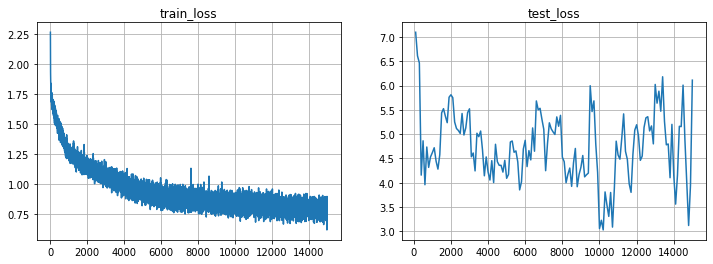

Mean loss=0.802


100%|██████████| 15000/15000 [19:18<00:00, 12.94it/s]


6962-4963=1999, predicted=1999, MAPE=0.0


941.9894647598267

In [ ]:
attentive_model = AttentiveModel(inp_voc, out_voc, rnn_type='LSTM', bid=True).to(device)
train_model(attentive_model, lr=1e-3, batch_size=64)

let's check 10 random samples from test set

In [ ]:
model = attentive_model
model.eval()
for _ in range(10):
  batch_ix = np.random.randint(len(dev_inp), size=1)
  batch_inp = inp_voc.to_matrix(dev_inp[batch_ix]).to(device)
  batch_out = out_voc.to_matrix(dev_out[batch_ix]).to(device)
  mask = model.out_voc.compute_mask(batch_out)  # [batch_size, out_len]
  targets_one_hot = F.one_hot(batch_out, len(model.out_voc)).to(torch.float32)
  logits_seq = model(batch_inp, batch_out)
  logprobs_seq = torch.log_softmax(logits_seq, dim=-1)
  y = dev_out[batch_ix][0]
  y_hat = model.translate_lines(dev_inp[batch_ix], device=device)[0][0].replace(" ", "")
  print(f"{dev_inp[batch_ix][0]}={y}, predicted={y_hat}")

2979+7601=10580, predicted=10730
6659+2634=9293, predicted=9233
8657+78=8735, predicted=8495
5385-6189=-804, predicted=-874
4521-1863=2658, predicted=2938
9135-3239=5896, predicted=5966
946-5851=-4905, predicted=-4975
2054*3424=7032896, predicted=6933344
5102*6665=34004830, predicted=34355330
5744*5228=30029632, predicted=30055568


attentive model is also not precise but it seems that answers are closer to correct 

## Good Luck!